Dataset Overview:
   User ID  Gender  Age Activity Level  Location  App Sessions  \
0        1  Female   22         Active  Suburban           151   
1        2    Male   50         Active     Rural           157   
2        3    Male   36         Active     Urban           178   
3        4  Female   36         Active  Suburban           155   
4        5    Male   34      Sedentary     Rural            95   

   Distance Travelled (km)  Calories Burned  
0                      140              728  
1                      115              523  
2                      163              795  
3                       85              715  
4                       71              439  

Data Summary:
           User ID          Age  App Sessions  Distance Travelled (km)  \
count  5000.000000  5000.000000   5000.000000              5000.000000   
mean   2500.500000    38.423600    124.366400                92.550400   
std    1443.520003    12.160631     42.689317                36.746095  

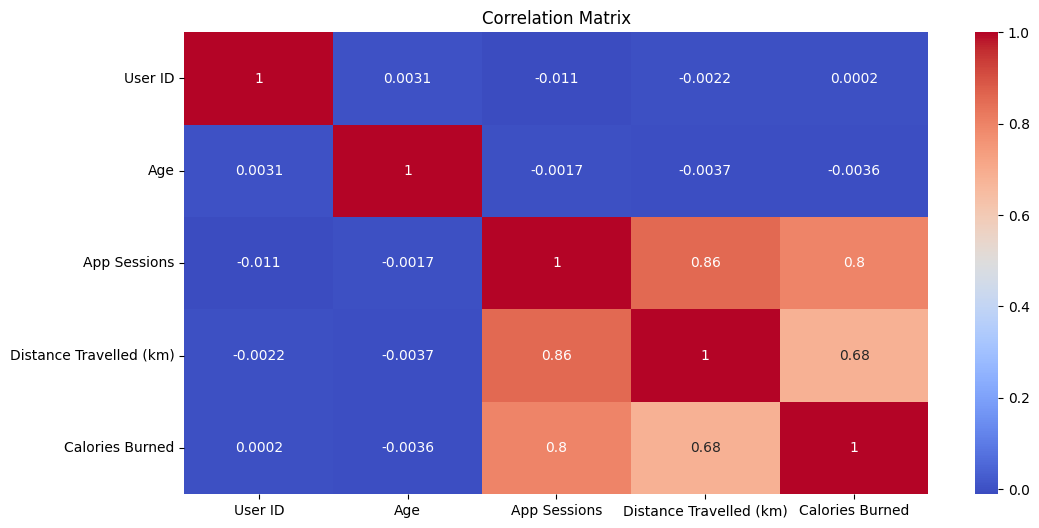


Regression Performance Metrics:
R²: 0.87
MAE: 13.41
RMSE: 15.84

Feature Importances:
cat__Activity Level_Active       0.691973
cat__Activity Level_Moderate     0.135650
cat__Activity Level_Sedentary    0.130426
num__Age                         0.026495
cat__Gender_Male                 0.003149
cat__Gender_Female               0.003126
cat__Location_Suburban           0.003084
cat__Location_Rural              0.003064
cat__Location_Urban              0.003033
dtype: float64


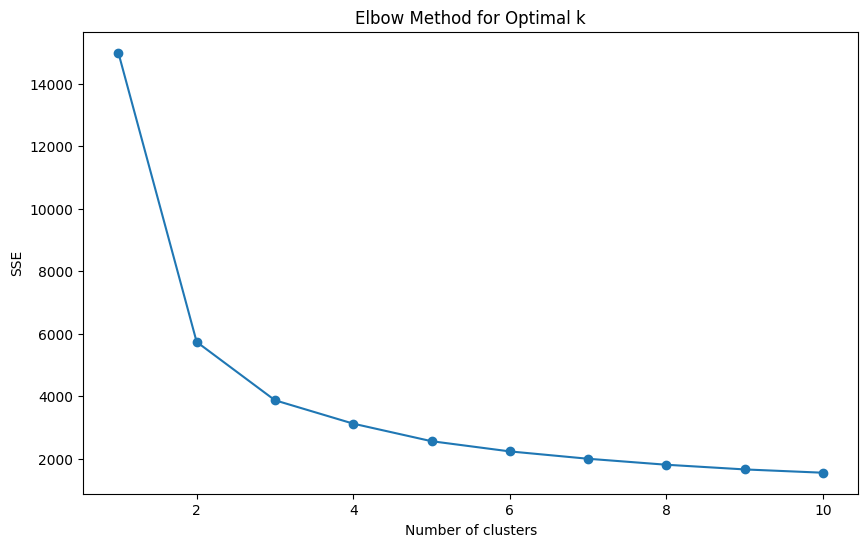


Cluster Profiles:
   Cluster  App Sessions  Distance Travelled (km)  Calories Burned        Age  \
0        0     77.037638                55.478286       254.920093  38.265200   
1        1    174.014453               134.043359       643.831383  38.268410   
2        2    129.640110                94.602198       431.783516  38.697802   

  Gender Activity Level  Location  
0   Male      Sedentary  Suburban  
1   Male         Active     Urban  
2   Male       Moderate     Rural  


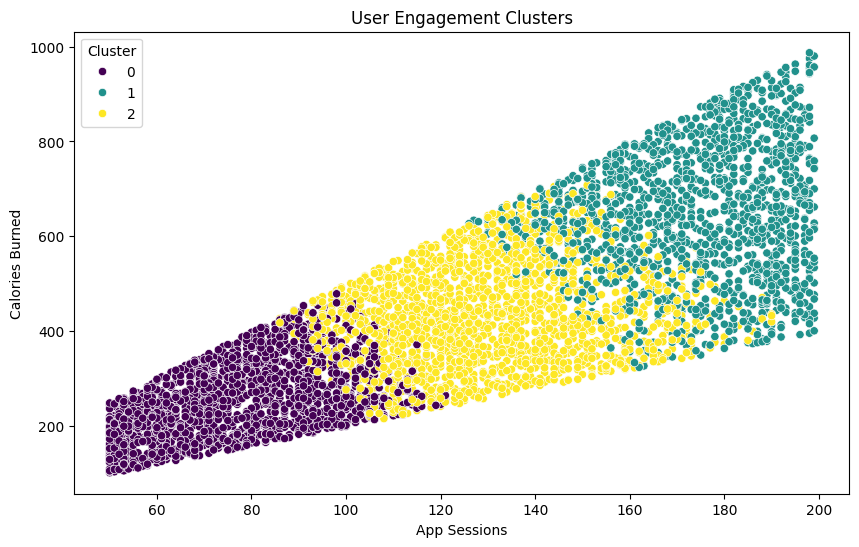

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load dataset
df = pd.read_csv('/Users/pekiou/Desktop/MSE/term 2/data/ass 2/dataset for assignment 2 (1).csv')

# Data cleaning
df = df.dropna()  # Remove incomplete records

# Exploratory Data Analysis
print("Dataset Overview:")
print(df.head())
print("\nData Summary:")
print(df.describe())
print("\nMissing Values Check:")
print(df.isnull().sum())

# Visualization
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Regression Analysis (Predict App Sessions)
# Features and target
X = df[['Age', 'Gender', 'Activity Level', 'Location']]
y = df['App Sessions']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age']),
        ('cat', OneHotEncoder(), ['Gender', 'Activity Level', 'Location'])
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Training
model.fit(X_train, y_train)

# Prediction and evaluation
y_pred = model.predict(X_test)

print("\nRegression Performance Metrics:")
print(f'R²: {r2_score(y_test, y_pred):.2f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}')

# Feature Importance
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importances = model.named_steps['regressor'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\nFeature Importances:")
print(feat_imp)

# Clustering Analysis
X_cluster = df[['App Sessions', 'Distance Travelled (km)', 'Calories Burned']]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Determine optimal clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

# Apply K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Cluster analysis
cluster_profile = df.groupby('Cluster').agg({
    'App Sessions': 'mean',
    'Distance Travelled (km)': 'mean',
    'Calories Burned': 'mean',
    'Age': 'mean',
    'Gender': lambda x: x.mode()[0],
    'Activity Level': lambda x: x.mode()[0],
    'Location': lambda x: x.mode()[0]
}).reset_index()

print("\nCluster Profiles:")
print(cluster_profile)

# Visualization of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='App Sessions', y='Calories Burned', hue='Cluster', palette='viridis')
plt.title('User Engagement Clusters')
plt.show()